In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/face-mask-detection


mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 392M/398M [00:03<00:00, 158MB/s]
100% 398M/398M [00:03<00:00, 127MB/s]


In [ ]:
!unzip face-mask-detection.zip

In [5]:
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [8]:
# path of images directory
dir_path = 'images'

# path of xml files directory
xml_path = 'annotations'

# List of Image file name 
file_list = os.listdir(dir_path)
annotation_list = os.listdir(xml_path)
# How many image files?
print('There are total {} images.'.format(len(annotation_list)))

There are total 853 images.


In [9]:
def read_annot(file_name, xml_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels
    """
    bbox = []
    labels = []
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'helmet':
            label_idx = 2
        elif label == 'head':
            label_idx = 1
        else:
            label_idx = 0
        labels.append(label_idx)
        
    return bbox, labels

# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=1):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # green
        elif label == 1:
            color = (0,0,225) # red
        else: 
            color = (225,0,0) # blue
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


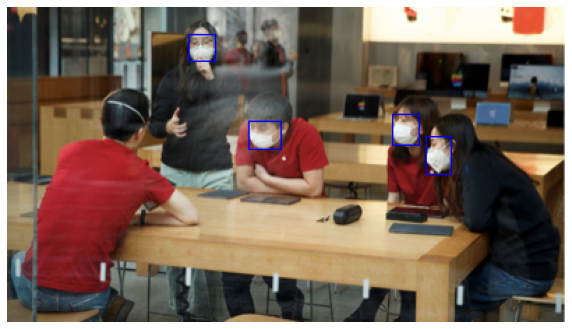

In [10]:
# Get the image randomly
image_name = file_list[random.randint(0,len(file_list))] # random select an image

# Get the bbox and label
bbox, labels  = read_annot(image_name, xml_path)

#draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path,image_name)), bbox,labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [12]:
from sklearn.model_selection import train_test_split
file_list.sort()
annotation_list.sort()
X_train, X_test, y_train, y_test = train_test_split(file_list, annotation_list, test_size=0.25, random_state=42)

In [13]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir
       
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [14]:
  mask_dataset = image_dataset(X_train, dir_path, xml_path)

  def collate_fn(batch):
      return tuple(zip(*batch))

  mask_loader = DataLoader(mask_dataset,
                          batch_size=2,
                          shuffle=True,
                          num_workers=2,
                          collate_fn=collate_fn)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [16]:
num_classes = 4 # including background

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [18]:
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs=10

In [ ]:
# Main training function
loss_list = []

for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in mask_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
    end = time.time()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))

In [ ]:
torch.save(model.state_dict(), './Mask_Detection_Model_v1.pth')

In [ ]:
img_name = X_test[5]
img_path = os.path.join(dir_path, img_name)
img = Image.open(img_path).convert('RGB')
img = transforms.ToTensor()(img)
model.eval()
    
with torch.no_grad():
    predictions = model(img.unsqueeze(0).to(device))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


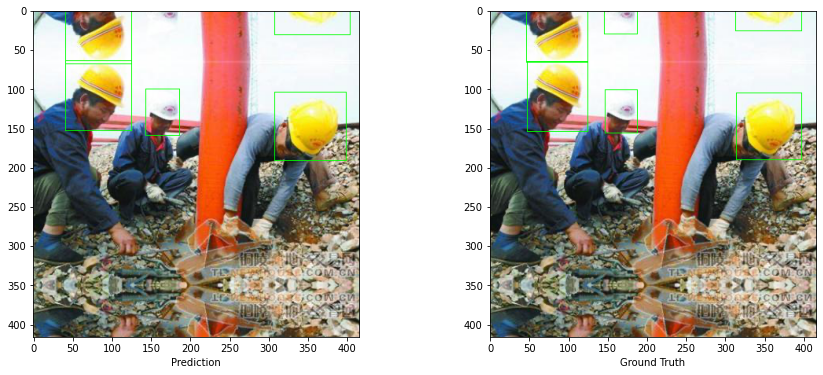

In [ ]:
idx = 19
test_img = Image.open(os.path.join(dir_path,X_test[idx])).convert('RGB')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Draw the bounding box of ground truth
bbox, labels  = read_annot(X_test[idx], xml_path)
#draw bounding boxes on the image
gt_output = draw_boxes(test_img, bbox,labels)

# Display the result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


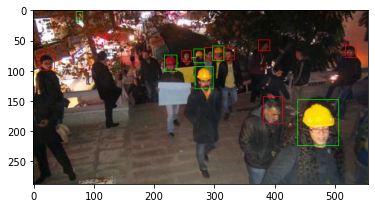

In [ ]:
test_img = Image.open("/content/Maden-işçileri-için-baret-takıp-madenci-yürüyüşü-yaptılar.jpg").convert('RGB')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)


# Display the result
plt.imshow(test_output)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


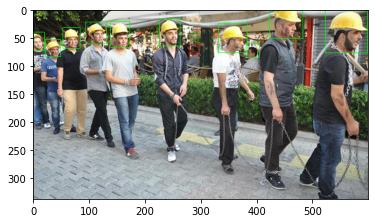

In [ ]:
test_img = Image.open("/content/55ea6fbbf018fbb8f87fd1e4.jpg").convert('RGB')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)


# Display the result
plt.imshow(test_output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


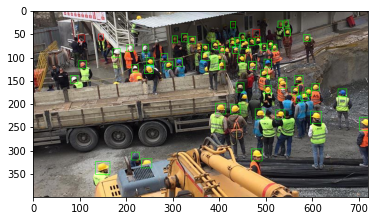

In [ ]:
test_img = Image.open("/content/ankara-da-300-insaat-iscisi-karantinada-hasta-isciyi-santiyeye-getirdiler-iddiasi-706098-5.jpg").convert('RGB')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)


# Display the result
plt.imshow(test_output)

In [ ]:
def get_iou(pred_box, gt_box):
    """
    pred_box : the coordinate for predict bounding box
    gt_box :   the coordinate for ground truth bounding box
    return :   the iou score
    the  left-down coordinate of  pred_box:(pred_box[0], pred_box[1])
    the  right-up coordinate of  pred_box:(pred_box[2], pred_box[3])
    """
    # 1.get the coordinate of intersection
    ixmin = max(pred_box[0], gt_box[0])
    ixmax = min(pred_box[2], gt_box[2])
    iymin = max(pred_box[1], gt_box[1])
    iymax = min(pred_box[3], gt_box[3])

    iw = np.maximum(ixmax-ixmin+1., 0.)
    ih = np.maximum(iymax-iymin+1., 0.)

    # 2. calculate the area of intersection
    inters = iw*ih

    # 3. calculate the area of union
    uni = ((pred_box[2]-pred_box[0]+1.) * (pred_box[3]-pred_box[1]+1.) +
           (gt_box[2] - gt_box[0] + 1.) * (gt_box[3] - gt_box[1] + 1.) -
           inters)

    # 4. calculate the overlaps between pred_box and gt_box
    iou = inters / uni

    return iou

In [ ]:
def match(gt_boxes, gt_labels, pred_boxes, pred_labels):
  pairs = []
  for y in range(len(pred_boxes)):
    for i in range(len(gt_boxes)):
      score = get_iou(gt_boxes[i], pred_boxes[y])
      if score >= 0.6:
          pair = [gt_boxes[i], gt_labels[i], pred_boxes[y], pred_labels[y]]
          pairs.append(pair)
  return pairs


def get_matches(idx):
  test_img = Image.open(os.path.join(dir_path,X_test[idx])).convert('RGB')
  # Predicted values
  test_img, test_boxes, test_labels = single_img_predict(test_img)
  test_boxes = test_boxes.tolist()
  test_labels = test_labels.tolist()
  # Ground truth values
  bbox, labels  = read_annot(X_test[idx], xml_path)
  matches = match(bbox, labels, test_boxes, test_labels)
  return matches
total_len = 0
combined_matches = []
for i in range(len(X_test)):
  m = get_matches(i)
  l = len(m)
  total_len+=l
  for k in m:
    combined_matches.append(k)

print(len(combined_matches))
print(total_len)

5170
5170


In [ ]:
gt_labels = []
predictions = []
for el in combined_matches:
  first = el[1]
  sec = el[3]
  gt_labels.append(first)
  predictions.append(sec)

In [ ]:
k = pd.Series(gt_labels)
k.value_counts()

2    3938
1    1227
0       5
dtype: int64

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       1.00      0.96      0.98      1227
           2       0.98      1.00      0.99      3938

    accuracy                           0.99      5170
   macro avg       0.66      0.65      0.66      5170
weighted avg       0.99      0.99      0.99      5170



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


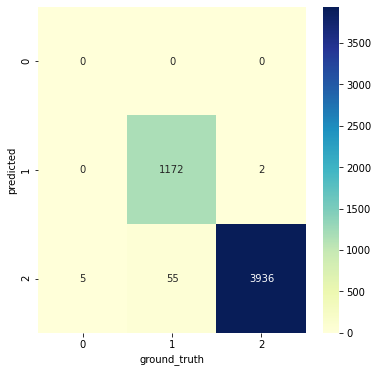

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sbn
c_m = confusion_matrix(predictions, gt_labels)
plt.figure(figsize=(6, 6))
sbn.heatmap(c_m, annot=True, cmap='YlGnBu', fmt='g', yticklabels= ['0', '1', '2'], xticklabels=['0', '1', '2'])
plt.xlabel('ground_truth')
plt.ylabel('predicted')
print(classification_report(gt_labels, predictions))